In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris, make_friedman1
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV, SequentialFeatureSelector
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import (
    impute,
    make_forecasting_frame,
    roll_time_series,
)

In [ ]:
df = pd.read_csv("train.csv")
df["service_date"] = pd.to_datetime(df["service_date"])
df = df.drop("index", axis=1)
# df = df.set_index("service_date")

In [ ]:
df

,service_date,service_status,sum_price,hotel_id,hotel_category_star,hotel_max_rooms,hotel_type,city_name,region_name,country_name
0,2018-10-03,"Аннулировано, без штрафа",5117.000000,1037,4.0,74.0,hotel,Якутск,Якутия,Россия
1,2019-04-02,Подтвержден,2850.899902,5222,0.0,15.0,mini-hotel,Белгород,Белгородская область,Россия
2,2023-09-28,Подтвержден,3700.000000,35751,3.0,16.0,hotel,Жуковский,Московская область,Россия
3,2019-04-27,Подтвержден,15603.200195,2428,2.0,37.0,hotel,Казань,Татарстан,Россия
4,2023-04-08,Подтвержден,5915.000000,103399,3.0,105.0,hotel,Краснодар,Краснодарский край,Россия
...,...,...,...,...,...,...,...,...,...,...
5408815,2020-11-24,Подтвержден,12320.000000,2267,3.0,74.0,hotel,Туапсе,Краснодарский край,Россия
5408816,2023-02-13,Подтвержден,3288.250000,3257,3.0,66.0,hotel,Черкесск,Карачаево-Черкессия,Россия
5408817,2022-09-26,Подтвержден,506.000000,13935,0.0,7.0,hostel,Уфа,Башкортостан,Россия
5408818,2022-06-06,Подтвержден,2500.000000,130933,3.0,26.0,hotel,Тверь,Тверская область,Россия


In [ ]:
(df["sum_price"] < 0).sum()

3

In [ ]:
df["sum_price"] = df["sum_price"].apply(lambda x: abs(x))

In [ ]:
train = df.groupby(["service_date"])["sum_price"].sum()
train

service_date
2011-09-06    6.800000e+03
2011-09-13    6.741000e+03
2012-01-27    7.360000e+03
2012-02-13    3.776000e+04
2012-03-02    2.400000e+03
                  ...     
2024-05-27    1.007527e+08
2024-05-28    1.003180e+08
2024-05-29    9.832966e+07
2024-05-30    1.000403e+08
2024-05-31    9.813730e+07
Name: sum_price, Length: 4203, dtype: float64

<Axes: xlabel='service_date'>

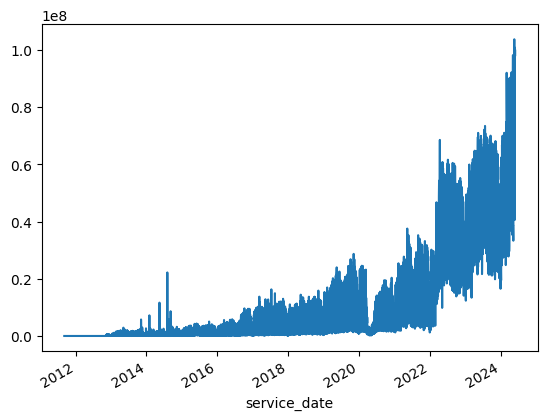

In [ ]:
train.plot()

<Axes: xlabel='service_date'>

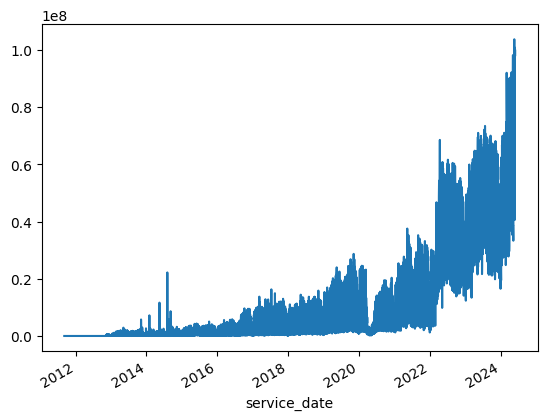

In [ ]:
train_after_covid = train[train.index > "2022-02-24"]
train_after_covid = train
train_after_covid.plot()

In [ ]:
# годовая и недельная сезонность
# ещё присутствует тренд, похоже на мультипликативный

In [ ]:
train_after_covid = train_after_covid.reset_index()

In [ ]:
train_after_covid.columns = ["date", "forecast_value"]

In [ ]:
submission = pd.read_csv("sample_submission.csv")
train_after_covid = pd.concat([train_after_covid, submission], axis=0)

In [ ]:
train_after_covid = train_after_covid.reset_index(drop=True)
train_after_covid["date"] = pd.to_datetime(train_after_covid["date"])

train_after_covid = train_after_covid.sort_values(by="date")

In [ ]:
def create_date_features(df):
    df = df.copy()
    df["month"] = df.date.dt.month.astype("int8")
    df["day_of_month"] = df.date.dt.day.astype("int8")
    df["day_of_year"] = df.date.dt.dayofyear.astype("int16")
    df["week_of_month"] = (df.date.apply(lambda d: (d.day - 1) // 7 + 1)).astype("int8")
    df["week_of_year"] = (df.date.dt.isocalendar().week).astype("int8")
    df["day_of_week"] = (df.date.dt.dayofweek + 1).astype("int8")
    df["year"] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    # df["quarter"] = df.date.dt.quarter.astype("int8")
    # df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    # df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    # df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    # df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    # df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    # df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    # df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    # df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    # df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")

    month_in_year = 12
    df["month_sin"] = np.sin(2 * np.pi * df.month / month_in_year)
    df["month_cos"] = np.cos(2 * np.pi * df.month / month_in_year)

    days_in_month = 30
    df["day_sin"] = np.sin(2 * np.pi * df.day_of_month / days_in_month)
    df["day_cos"] = np.cos(2 * np.pi * df.day_of_month / days_in_month)

    days_in_year = 365
    df["day_of_year_sin"] = np.sin(2 * np.pi * df.day_of_year / days_in_year)
    df["day_of_year_cos"] = np.cos(2 * np.pi * df.day_of_year / days_in_year)

    weeks_in_year = 52.1429
    df["week_of_year_sin"] = np.sin(2 * np.pi * df.week_of_year / weeks_in_year)
    df["week_of_year_cos"] = np.cos(2 * np.pi * df.week_of_year / weeks_in_year)

    # quarters_in_year = 4
    # df['quarter_sin'] = np.sin(2*np.pi*df.quarter/quarters_in_year)
    # df['quarter_cos'] = np.cos(2*np.pi*df.quarter/quarters_in_year)

    # seasons_in_year = 4
    # df['season_sin'] = np.sin(2*np.pi*df.season/seasons_in_year)
    # df['season_cos'] = np.cos(2*np.pi*df.season/seasons_in_year)

    return df


train_after_covid_with_features = create_date_features(train_after_covid)

In [ ]:
def create_rolling_features(df, column, lags, windows, ew_windows):
    df = df.copy()
    for lag in lags:
        lagged_col = df[column].shift(lag)

        df[f"lag_{lag}"] = lagged_col

        for window in windows:

            df[f"rolling_mean_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window, min_periods=1
            ).mean()
            df[f"rolling_median_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window, min_periods=1
            ).median()

            df[f"rolling_mean_lag{lag}_win{window}_dow"] = df.groupby("day_of_week")[
                column
            ].transform(
                lambda x: x.shift(lag // 7).rolling(window=window, min_periods=1).mean()
            )

            df[f"rolling_median_lag{lag}_win{window}_dow"] = df.groupby("day_of_week")[
                column
            ].transform(
                lambda x: x.shift(lag // 7).rolling(window=window, min_periods=1).median()
            )

            df[f"rolling_sum_lag{lag}_win{window}_dow"] = df.groupby("day_of_week")[
                column
            ].transform(
                lambda x: x.shift(lag // 7).rolling(window=window, min_periods=1).sum()
            )

            df[f"rolling_sum_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window, min_periods=1
            ).sum()

            # # Min and Max
            # df[f'rolling_min_lag{lag}_win{window}'] = lagged_col.rolling(window=window, min_periods=1).min()
            # df[f'rolling_max_lag{lag}_win{window}'] = lagged_col.rolling(window=window, min_periods=1).max()

            # # Standard Deviation
            # df[f'rolling_std_lag{lag}_win{window}'] = lagged_col.rolling(window=window, min_periods=1).std()

            # # Skewness
            # df[f'rolling_skew_lag{lag}_win{window}'] = lagged_col.rolling(window=window, min_periods=1).skew()
            # # kurt
            # df[f'rolling_skew_lag{lag}_win{window}'] = lagged_col.rolling(window=window, min_periods=1).kurt()
            # Percentiles
            df[f"rolling_10th_percentile_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window, min_periods=1
            ).quantile(0.1)
            df[f"rolling_90th_percentile_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window, min_periods=1
            ).quantile(0.9)

            df[f"rolling_10th_percentile_lag{lag}_win{window}_dow"] = df.groupby(
                "day_of_week"
            )[column].transform(
                lambda x: x.shift(lag // 7)
                .rolling(window=window, min_periods=1)
                .quantile(0.1)
            )

            df[f"rolling_90th_percentile_lag{lag}_win{window}_dow"] = df.groupby(
                "day_of_week"
            )[column].transform(
                lambda x: x.shift(lag // 7)
                .rolling(window=window, min_periods=1)
                .quantile(0.9)
            )

        # for ew_window in ew_windows:
        #     df[f'ewm_mean_lag{lag}_win{ew_window}'] = lagged_col.ewm(span=ew_window).mean()
        #     df[f'ewm_sum_lag{lag}_win{ew_window}'] = lagged_col.ewm(span=ew_window).sum()
        # df[f'ewm_std_lag{lag}_win{ew_window}'] = lagged_col.ewm(span=ew_window).std()
        # df[f'ewm_var_lag{lag}_win{ew_window}'] = lagged_col.ewm(span=ew_window).var()
        # df[f'ewm_corr_lag{lag}_win{ew_window}'] = lagged_col.ewm(span=ew_window).corr()
    return df


# lags= [31, 38, 45]
# windows = [7, 14, 21, 28, 35, 42, 56]
ew_windows = [7, 14, 21, 28, 35, 42, 56]
lags = [31, 35, 48]
windows = [7, 14, 21, 28, 35, 42]
# lags = [31, 62]
# windows = [7, 14, 28, 56]
# lags = [31, 38]
# windows = [7, 14, 21, 28, 35, 42]

In [ ]:
catboost_train = create_rolling_features(
    train_after_covid_with_features, "forecast_value", lags, windows, ew_windows
)[max(lags) + max(windows) - 1 :]
catboost_train

/tmp/ipykernel_236161/2997153884.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'rolling_median_lag{lag}_win{window}_dow'] = (
/tmp/ipykernel_236161/2997153884.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'rolling_sum_lag{lag}_win{window}_dow'] = (
/tmp/ipykernel_236161/2997153884.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

,date,forecast_value,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,is_wknd,...,rolling_mean_lag45_win42,rolling_median_lag45_win42,rolling_mean_lag45_win42_dow,rolling_median_lag45_win42_dow,rolling_sum_lag45_win42_dow,rolling_sum_lag45_win42,rolling_10th_percentile_lag45_win42,rolling_90th_percentile_lag45_win42,rolling_10th_percentile_lag45_win42_dow,rolling_90th_percentile_lag45_win42_dow
86,2013-02-02,3050.000000,2,2,33,1,5,6,2013,1,...,1.876927e+05,5.548600e+04,1.757000e+04,1.757000e+04,3.514000e+04,7.883095e+06,3.555100e+03,5.435089e+05,8.474000e+03,2.666600e+04
87,2013-02-03,14525.000000,2,3,34,1,5,7,2013,1,...,1.972250e+05,7.373450e+04,4.600000e+03,4.600000e+03,4.600000e+03,8.283450e+06,3.555100e+03,5.435089e+05,4.600000e+03,4.600000e+03
88,2013-02-04,372485.069824,2,4,35,1,6,1,2013,0,...,2.019951e+05,7.440350e+04,1.977414e+05,3.776000e+04,1.779672e+06,8.483793e+06,3.555100e+03,5.435089e+05,7.983200e+03,5.424540e+05
89,2013-02-05,430987.000000,2,5,36,1,6,2,2013,0,...,2.138268e+05,1.333627e+05,1.801795e+05,1.346999e+05,1.801795e+06,8.980726e+06,3.555100e+03,5.435089e+05,6.418400e+03,4.188467e+05
90,2013-02-06,399826.259766,2,6,37,1,6,3,2013,0,...,2.178262e+05,1.989559e+05,2.517433e+05,2.662835e+05,1.762203e+06,9.148702e+06,3.555100e+03,5.435089e+05,1.269628e+05,3.794927e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4228,2024-06-26,0.000000,6,26,178,4,26,3,2024,0,...,6.561691e+07,7.741364e+07,6.455650e+07,6.365829e+07,2.711373e+09,2.755910e+09,3.604056e+07,8.854322e+07,4.881423e+07,7.996687e+07
4229,2024-06-27,0.000000,6,27,179,4,26,4,2024,0,...,6.597823e+07,7.741364e+07,6.450215e+07,6.560792e+07,2.709090e+09,2.771086e+09,3.604056e+07,9.008005e+07,5.192083e+07,8.081272e+07
4230,2024-06-28,0.000000,6,28,180,4,26,5,2024,1,...,6.623021e+07,7.741364e+07,6.275337e+07,6.357712e+07,2.635642e+09,2.781669e+09,3.604056e+07,9.077280e+07,3.883639e+07,7.775459e+07
4231,2024-06-29,0.000000,6,29,181,5,26,6,2024,1,...,6.659291e+07,7.741364e+07,2.911536e+07,2.751963e+07,1.222845e+09,2.796902e+09,3.604056e+07,9.199718e+07,2.254304e+07,3.786343e+07


In [ ]:
catboost_train = catboost_train.drop("date", axis=1)

In [ ]:
X_train = catboost_train[: -len(submission)].drop("forecast_value", axis=1)
y_train = catboost_train[: -len(submission)]["forecast_value"]
X_test = catboost_train[-len(submission) :].drop("forecast_value", axis=1)

In [ ]:
# # tscv =


sfs = SequentialFeatureSelector(
    CatBoostRegressor(iterations=1000, has_time=True),
    n_features_to_select=10,
    cv=TimeSeriesSplit(n_splits=3),
    n_jobs=2,
)

sfs.fit(X_train, y_train)

In [ ]:
selector = RFE(
    CatBoostRegressor(iterations=1000, has_time=True), n_features_to_select=15, step=1
)

selector = selector.fit(X_train, y_train)

Learning rate set to 0.051202
0:	learn: 18725624.3246234	total: 1.96ms	remaining: 1.96s
1:	learn: 17920273.3787515	total: 3.98ms	remaining: 1.99s
2:	learn: 17136123.6669203	total: 5.92ms	remaining: 1.97s
3:	learn: 16402115.5596994	total: 7.74ms	remaining: 1.93s
4:	learn: 15703529.6795400	total: 9.7ms	remaining: 1.93s
5:	learn: 15057335.8525719	total: 11.7ms	remaining: 1.93s
6:	learn: 14445840.7721223	total: 13.5ms	remaining: 1.92s
7:	learn: 13842362.9376097	total: 15.4ms	remaining: 1.91s
8:	learn: 13274342.0994475	total: 17.2ms	remaining: 1.9s
9:	learn: 12722867.2538178	total: 18.8ms	remaining: 1.86s
10:	learn: 12208553.7778372	total: 20.2ms	remaining: 1.81s
11:	learn: 11735737.2134137	total: 21.5ms	remaining: 1.77s
12:	learn: 11298499.6132475	total: 23.7ms	remaining: 1.8s
13:	learn: 10881347.2052657	total: 25.1ms	remaining: 1.77s
14:	learn: 10483524.1187648	total: 26.5ms	remaining: 1.74s
15:	learn: 10100641.7680896	total: 28ms	remaining: 1.72s
16:	learn: 9732805.5929991	total: 29.5ms	

In [ ]:
X_test = X_test[X_test.columns[selector.support_]]
X_train = X_train[X_train.columns[selector.support_]]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 25 but corresponding boolean dimension is 199

In [ ]:
X_train

,day_of_year,day_of_year_sin,day_of_year_cos,week_of_year_cos,rolling_mean_lag31_win7_dow,rolling_90th_percentile_lag31_win7_dow,rolling_90th_percentile_lag31_win14_dow,rolling_median_lag31_win35_dow,rolling_90th_percentile_lag31_win35_dow,rolling_90th_percentile_lag31_win42_dow,rolling_10th_percentile_lag38_win7,rolling_90th_percentile_lag38_win7_dow,rolling_10th_percentile_lag38_win28,rolling_median_lag38_win42_dow,rolling_median_lag45_win7_dow
86,33,0.538005,0.842942,0.823923,2.151475e+04,3.991530e+04,3.991530e+04,1.762000e+04,3.991530e+04,3.991530e+04,1.202327e+05,2.441200e+04,6.270000e+03,6.300000e+03,1.757000e+04
87,34,0.552435,0.833556,0.823923,2.710333e+04,6.056000e+04,6.056000e+04,4.600000e+03,6.056000e+04,6.056000e+04,1.202327e+05,6.755500e+04,6.270000e+03,3.957500e+04,4.600000e+03
88,35,0.566702,0.823923,0.749827,3.209378e+05,5.427554e+05,5.421526e+05,1.474740e+05,5.421526e+05,5.421526e+05,1.062723e+05,5.427554e+05,5.407500e+04,1.700561e+05,3.023521e+05
89,36,0.580800,0.814046,0.749827,2.128184e+05,4.539194e+05,3.951740e+05,7.266467e+04,3.951740e+05,3.951740e+05,8.015370e+04,4.539194e+05,5.407500e+04,7.321200e+04,2.246632e+05
90,37,0.594727,0.803928,0.749827,2.575198e+05,4.610121e+05,4.574515e+05,2.662835e+05,4.574515e+05,4.574515e+05,2.929140e+04,3.794927e+05,3.312330e+04,2.366836e+05,2.662835e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4198,148,0.559589,-0.828770,-0.882047,7.562007e+07,8.685578e+07,8.799585e+07,6.351879e+07,8.548511e+07,8.490420e+07,3.786005e+07,8.729722e+07,3.333397e+07,6.406206e+07,8.562998e+07
4199,149,0.545240,-0.838280,-0.882047,7.636840e+07,8.818650e+07,8.443159e+07,6.529636e+07,8.047032e+07,7.938817e+07,3.730902e+07,8.818650e+07,3.596914e+07,6.567109e+07,7.945941e+07
4200,150,0.530730,-0.847541,-0.882047,7.350774e+07,8.399920e+07,8.020789e+07,6.358961e+07,7.776612e+07,7.709051e+07,3.938506e+07,8.399920e+07,3.739973e+07,6.397679e+07,7.709251e+07
4201,151,0.516062,-0.856551,-0.882047,7.941350e+07,8.495111e+07,8.369332e+07,6.555841e+07,8.042786e+07,7.965214e+07,3.938506e+07,8.495111e+07,3.739973e+07,6.590009e+07,8.094101e+07


In [ ]:
model = CatBoostRegressor(iterations=1000, has_time=True)
# model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_depth=15)

model.fit(X_train, y_train)


pred = model.predict(X_test)

Learning rate set to 0.051202
0:	learn: 18748221.2399940	total: 1.51ms	remaining: 1.51s
1:	learn: 17925902.5978213	total: 2.8ms	remaining: 1.4s
2:	learn: 17124431.5014175	total: 4.33ms	remaining: 1.44s
3:	learn: 16392966.2493027	total: 5.94ms	remaining: 1.48s
4:	learn: 15702771.0242633	total: 8.04ms	remaining: 1.6s
5:	learn: 15024663.3186505	total: 9.55ms	remaining: 1.58s
6:	learn: 14394968.2038385	total: 10.7ms	remaining: 1.52s
7:	learn: 13792257.5762816	total: 12ms	remaining: 1.49s
8:	learn: 13229864.4029423	total: 13.3ms	remaining: 1.47s
9:	learn: 12706993.4224304	total: 14.5ms	remaining: 1.43s
10:	learn: 12210804.4314922	total: 15.5ms	remaining: 1.4s
11:	learn: 11725570.6523782	total: 16.6ms	remaining: 1.36s
12:	learn: 11272882.4236640	total: 17.6ms	remaining: 1.34s
13:	learn: 10852341.8605881	total: 18.7ms	remaining: 1.32s
14:	learn: 10447152.9465800	total: 19.8ms	remaining: 1.3s
15:	learn: 10063768.7703614	total: 20.8ms	remaining: 1.28s
16:	learn: 9714174.5744447	total: 21.8ms	re

In [ ]:
model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    feature_fraction=0.3,
    subsample=0.2,
    num_leaves=10,
    metric="rmse",
    force_col_wise=True,
)


model.fit(X_train, y_train)

pred = model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Info] Total Bins 3609
[LightGBM] [Info] Number of data points in the train set: 4117, number of used features: 15
[LightGBM] [Info] Start training from score 14800779.402726
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3


In [ ]:
pd.DataFrame(zip(X_train.columns, model.feature_importances_)).sort_values(
    by=1, ascending=False
).head(50)

,0,1
0,day_of_year,92
1,day_of_year_sin,86
3,week_of_year_cos,82
12,rolling_10th_percentile_lag38_win28,74
13,rolling_median_lag38_win42_dow,69
2,day_of_year_cos,65
8,rolling_90th_percentile_lag31_win35_dow,60
10,rolling_10th_percentile_lag38_win7,58
4,rolling_mean_lag31_win7_dow,56
14,rolling_median_lag45_win7_dow,52


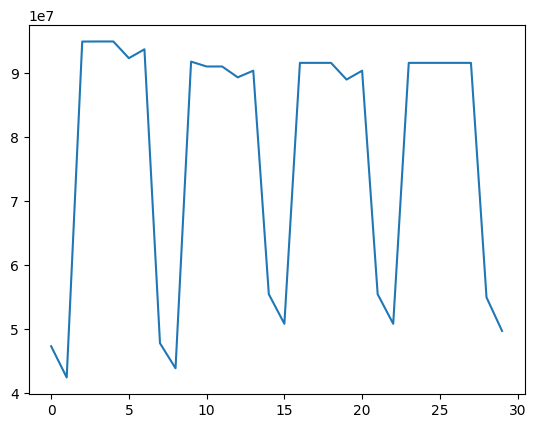

In [ ]:
plt.plot(pred)

<Axes: >

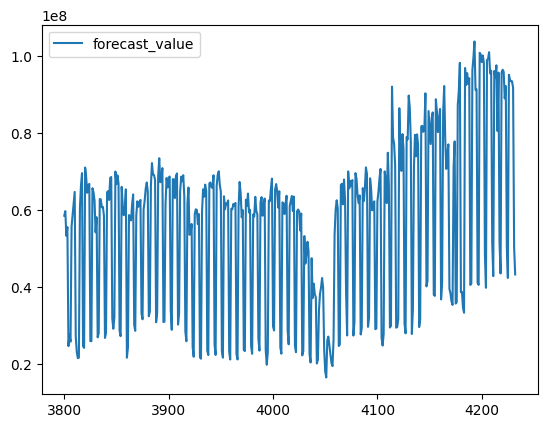

In [ ]:
submission["forecast_value"] = pred
pd.concat([train_after_covid.iloc[:-30], submission]).drop("date", axis=1).reset_index(
    drop=True
).iloc[3800:].plot()
# plt.axvline(827)

In [ ]:
submission.to_csv("catboost_1.csv", index=False)

In [ ]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best RMSE Score: {grid_search.best_score_}")

plt.plot(grid_search.predict(X_test))

In [ ]:
train_after_covid.shift(29)

,date,forecast_value
0,NaT,NaN
1,NaT,NaN
2,NaT,NaN
3,NaT,NaN
4,NaT,NaN
...,...,...
852,2024-05-28,1.003180e+08
853,2024-05-29,9.832966e+07
854,2024-05-30,1.000403e+08
855,2024-05-31,9.813730e+07


In [ ]:
model = CatBoostRegressor(verbose=0)

param_grid = {
    "iterations": [500, 1000, 1500],
    "learning_rate": [None, 0.03, 0.1],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "loss_function": ["RMSE"],
}

tscv = TimeSeriesSplit(n_splits=3)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=tscv,
    verbose=3,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

In [ ]:
train_after_covid

,date,forecast_value
0,2022-02-25,2.784901e+07
1,2022-02-26,4.872699e+06
2,2022-02-27,3.604619e+06
3,2022-02-28,2.415991e+07
4,2022-03-01,2.112790e+07
...,...,...
852,2024-06-26,0.000000e+00
853,2024-06-27,0.000000e+00
854,2024-06-28,0.000000e+00
855,2024-06-29,0.000000e+00


In [ ]:
# import pandas as pd
# from sklearn.model_selection import TimeSeriesSplit
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_squared_error


# tscv = TimeSeriesSplit(n_splits=5)
# cv_results = []

# for train_index, test_index in tscv.split(X_train):
#     model = CatBoostRegressor()
#     cv_X_train, cv_X_test = X_train.iloc[train_index], X_train.iloc[test_index]
#     cv_y_train, cv_y_test = y_train.iloc[train_index], y_train.iloc[test_index]

#     model.fit(cv_X_train, cv_y_train)


#     y_pred = model.predict(cv_X_test)
#     rmse = mean_squared_error(cv_y_test, y_pred, squared=False)
#     cv_results.append(rmse)
#     print(f'Fold RMSE: {rmse}')

# print(f'Mean RMSE: {sum(cv_results) / len(cv_results)}')
# np.mean(cv_results)

In [ ]:
test_training = train_after_covid.copy()
test_training["id"] = 1
df_rolled = roll_time_series(
    test_training["forecast_value"].shift(30).loc[30:],
    column_id="id",
    column_sort="date",
    max_timeshift=30,
    min_timeshift=5,
    rolling_direction=1,
)

df_rolled.head(35)

AttributeError: The given column for the id is not present in the data.

In [ ]:
test_training.shift(30)

,date,forecast_value,id
0,NaT,NaN,NaN
1,NaT,NaN,NaN
2,NaT,NaN,NaN
3,NaT,NaN,NaN
4,NaT,NaN,NaN
...,...,...,...
852,2024-05-27,1.007527e+08,1.0
853,2024-05-28,1.003180e+08,1.0
854,2024-05-29,9.832966e+07,1.0
855,2024-05-30,1.000403e+08,1.0


In [ ]:
df_rolled[df_rolled["id"] == df_rolled.loc[1398]["id"]]

,date,forecast_value,id
1394,2022-02-25,2.784901e+07,"(1, 2022-03-06 00:00:00)"
1395,2022-02-26,4.872699e+06,"(1, 2022-03-06 00:00:00)"
1396,2022-02-27,3.604619e+06,"(1, 2022-03-06 00:00:00)"
1397,2022-02-28,2.415991e+07,"(1, 2022-03-06 00:00:00)"
1398,2022-03-01,2.112790e+07,"(1, 2022-03-06 00:00:00)"
1399,2022-03-02,2.119904e+07,"(1, 2022-03-06 00:00:00)"
1400,2022-03-03,2.147315e+07,"(1, 2022-03-06 00:00:00)"
1401,2022-03-04,2.092735e+07,"(1, 2022-03-06 00:00:00)"
1402,2022-03-05,2.830259e+07,"(1, 2022-03-06 00:00:00)"
1403,2022-03-06,1.223718e+07,"(1, 2022-03-06 00:00:00)"


,date,forecast_value,id
5070,2022-02-25,2.784901e+07,"(1, 2022-03-27 00:00:00)"
5071,2022-02-26,4.872699e+06,"(1, 2022-03-27 00:00:00)"
5072,2022-02-27,3.604619e+06,"(1, 2022-03-27 00:00:00)"
5073,2022-02-28,2.415991e+07,"(1, 2022-03-27 00:00:00)"
5074,2022-03-01,2.112790e+07,"(1, 2022-03-27 00:00:00)"
...,...,...,...
81037,2024-06-26,0.000000e+00,"(1, 2024-06-30 00:00:00)"
81038,2024-06-27,0.000000e+00,"(1, 2024-06-30 00:00:00)"
81039,2024-06-28,0.000000e+00,"(1, 2024-06-30 00:00:00)"
81040,2024-06-29,0.000000e+00,"(1, 2024-06-30 00:00:00)"


In [ ]:
# Sample DataFrame with date and value
data = {
    "date": pd.date_range(start="2023-01-01", periods=100, freq="D"),
    "value": np.random.rand(100),
}
df = pd.DataFrame(data)

# Define the lags you want to create
lags = [30, 37]

# Create lagged features
for lag in lags:
    df[f"value_lag_{lag}"] = df["value"].shift(lag)

# Drop the rows where any lagged value is NaN (due to the shift)
df = df.dropna()

# Prepare the dataframe for tsfresh by adding 'id' and 'time' columns
# Here, we assume that all data belongs to one time series (id=1)
df["id"] = 1
df["time"] = np.arange(len(df))

# Melt the dataframe to long format for tsfresh
df_long = pd.melt(
    df, id_vars=["id", "time"], value_vars=[f"value_lag_{lag}" for lag in lags]
)

# Use tsfresh to extract features from the lagged columns
extracted_features = extract_features(df_long, column_id="id", column_sort="time")

# View the extracted features
print(extracted_features.head())

/home/seara/Desktop/Github/mtc-time-series/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


ValueError: value_name (value) cannot match an element in the DataFrame columns.